# <h1 style="text-align: center;">Optimal Control of TCLab using a Gaussian process regression embedded in Pyomo - notebook v4</h1>

<p style="text-align: center;">Alex Dowling<sup>1</sup>, Jacob P. Krell<sup>2</sup>

<p style="text-align: center;"><sup>1</sup>Department of Chemical and Biomolecular Engineering, University of Notre Dame, Notre Dame, IN 46556, USA <br>
<sup>2</sup>Department of Mechanical and Aerospace Engineering, West Virginia University, Morgantown, WV, 26506-6106, USA</p>

## Outline

- [Introduction](#introduction)
- [Benchmark](#benchmark)
- [Derivative of Smoothed Measurements](#derivative-of-smoothed-data)
    - [Smoothing](#smoothing)
    - [Derivative](#derivative)
- [GP Model of Derivative](#gp-model-of-derivative)
- [Results](#results)

## Introduction

The scope of this notebook is concerned only with $T_{S,1}$ and $Q_1$.

In [4]:
import os
dir = os.path.abspath('')  # directory of notebook
import pandas as pd
import numpy as np
from FoKL import FoKLRoutines
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [5]:
# Load data:
filename = "tclab_sine_test.csv"
data = pd.read_csv(os.path.join(dir, filename))

# Parse data:
tvec = data["Time"].values
Q1 = data["Q1"].values
TS1 = data["T1"].values

# Analytic expressions of heater power:
Q1f = lambda t: 50 * np.sin(30 * np.pi * t / tvec[-1]) + 50
dQ1f = lambda t: 1500 * np.sin(30 * np.pi * t / tvec[-1]) * np.pi / tvec[-1]


## Benchmark

Predicting temperatures via the two-state ODE,

In [3]:
alpha = 0.00016                                                                     # watts / (units P1 * percent U1)
P1 = 200                                                                            # P1 units
T_amb = TS1[0]  # ambient temperature

IC = [T_amb, T_amb]  # initial condition of states [TH1, TS1]
CpH =  7.006         # J/degC
CpS = 0.01           # J/degC
Ua =  0.051          # W/degC
Ub =  0.001          # W/degC

In [15]:
def dy_benchmark(t, y):
    """Benchmark ODE, for TS1."""
    TH1, TS1 = y
    dTH1 = (Ua * (T_amb - TH1) + Ub * (TS1 - TH1) + alpha * P1 * Q1f(t)) / CpH
    dTS1 = Ub * (TH1 - TS1) / CpS
    return [dTH1, dTS1]

soln_benchmark = solve_ivp(dy_benchmark, [tvec[0], tvec[-1]], IC, t_eval=tvec)

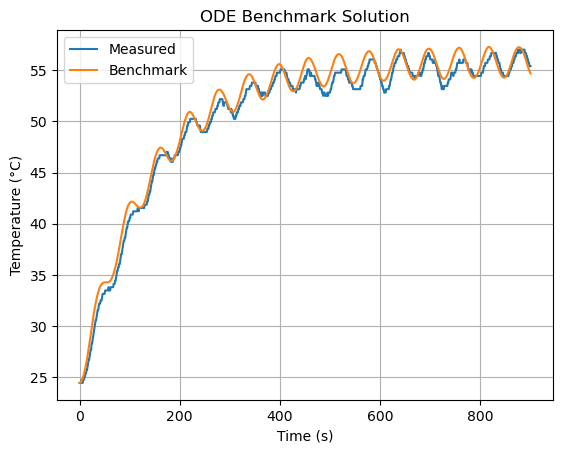

In [18]:
TS1_benchmark = soln_benchmark.y[1]

plt.figure()
plt.plot(tvec, TS1)
plt.plot(tvec, TS1_benchmark)
plt.grid()
plt.title('ODE Benchmark Solution')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
_ = plt.legend(['Measured', 'Benchmark'])

## Derivative of Smoothed Data

Since raw measurements are noisy, a smoothing functions is applied before calculating the time derivative.

### Smoothing

Using a GP as the smoothing function,

In [14]:
GP_T = FoKLRoutines.FoKL(kernel=1, UserWarnings=False)
_ = GP_T.fit([tvec, Q1], TS1, clean=True)

[1, 3592.127247512837]
[2, 3587.245251431803]
[2, 2325.6195698812176]
[3, 2307.576809156444]
[3, 574.1060402705099]
[4, 574.1060402705099]
[4, 540.9138514384176]
[4, -331.62357408654935]
[5, -331.62357408654935]
[5, -331.62357408654935]
[5, -384.5296810595524]
[6, -384.5296810595524]
[6, -384.5296810595524]
[6, -391.2268172424733]
[6, -394.6888620369673]
[7, -394.6888620369673]
[7, -394.6888620369673]
[7, -390.73500263956225]


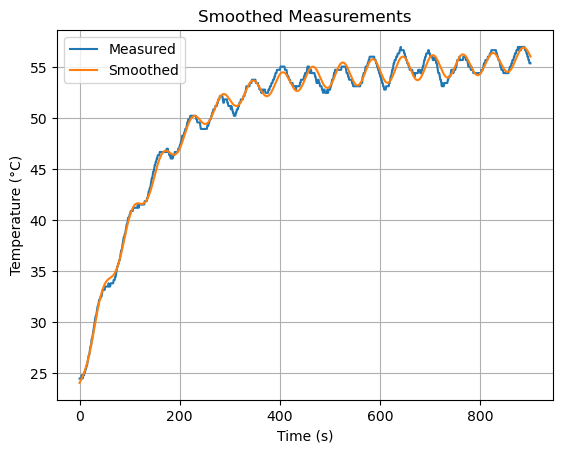

In [45]:
TS1_smooth = GP_T.evaluate()

plt.figure()
plt.plot(tvec, TS1)
plt.plot(tvec, TS1_smooth)
plt.grid()
plt.title('Smoothed Measurements')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
_ = plt.legend(['Measured', 'Smoothed'])

### Derivative

Applying the chain rule to obtain training data,

In [27]:
dGP = GP_T.bss_derivatives()  # gradient of GP_T

dGPdt = interp1d(tvec, dGP[:, 0])
dGPdQ1 = interp1d(tvec, dGP[:, 1])
dTS1f = lambda t: dGPdt(t) + dGPdQ1(t) * dQ1f(t)  # interpolation function

dTS1 = dTS1f(tvec)  # evaluate interpolation function at tvec to form training data
# == dTS1 = dGP[:, 0] + dGP[:, 1] * dQ1f(tvec)

Validating training data:

In [67]:
def dy_training(t, y):
    """ODE to integrate GP's training data'."""
    return [dTS1f(t)]

soln_training = solve_ivp(dy_training, [tvec[0], tvec[-1]], [TS1_smooth[0]], t_eval=tvec)

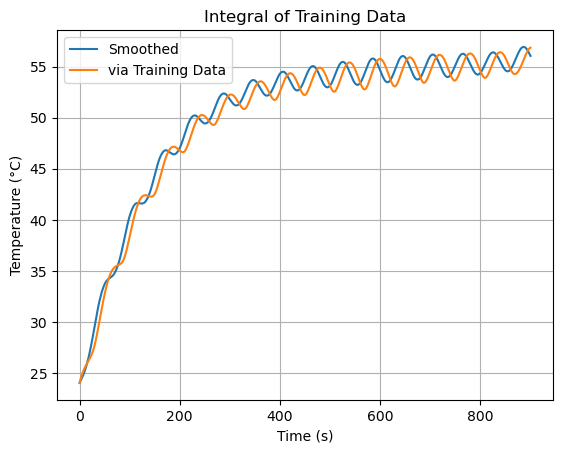

In [68]:
TS1_training = soln_training.y[0]

plt.figure()
plt.plot(tvec, TS1_smooth)
plt.plot(tvec, TS1_training)
plt.grid()
plt.title('Integral of Training Data')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
_ = plt.legend(['Smoothed', 'via Training Data'])

## GP Model of Derivative

In [28]:
GP_dT = FoKLRoutines.FoKL(kernel=1, UserWarnings=False)
_ = GP_dT.fit([TS1, Q1], dTS1, clean=True)

[1, -7264.438719603202]
[2, -7388.394692612204]
[2, -7415.588310376061]
[3, -7606.509972929768]
[3, -7628.300483045146]
[4, -7625.583846264189]
[4, -7789.209948765261]
[4, -7979.768112590997]
[5, -7975.291448404286]
[5, -7969.085317298936]
[5, -8110.693965573824]
[6, -8110.693965573824]
[6, -8110.693965573824]
[6, -8142.562104849645]
[6, -8159.549088127599]
[7, -8159.549088127599]
[7, -8164.456186145645]
[7, -8260.216444383746]
[7, -8255.887971583052]
[8, -8255.887971583052]
[8, -8255.887971583052]


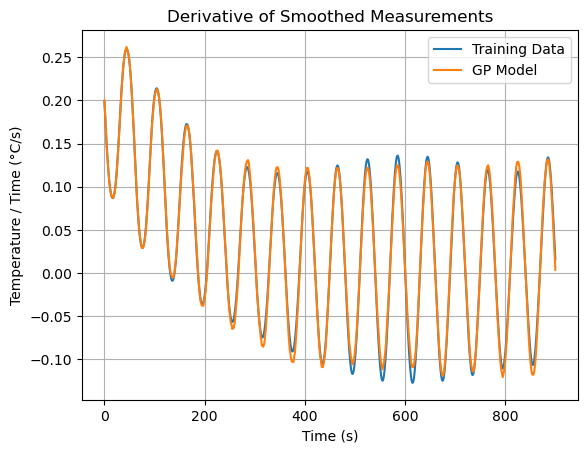

In [73]:
dTS1_GP = GP_dT.evaluate()

plt.figure()
plt.plot(tvec, dTS1)
plt.plot(tvec, dTS1_GP)
plt.grid()
plt.title('Derivative of Smoothed Measurements')
plt.xlabel('Time (s)')
plt.ylabel('Temperature / Time (°C/s)')
_ = plt.legend(['Training Data', 'GP Model'])

In [79]:
def dy_GP(t, y):
    """ODE to integrate GP of derivative."""
    return [GP_dT.evaluate([y[0], Q1f(t)], clean=True, SingleInstance=True)[0]]

soln_GP = solve_ivp(dy_GP, [tvec[0], tvec[-1]], [TS1_smooth[0]], 'LSODA', tvec)

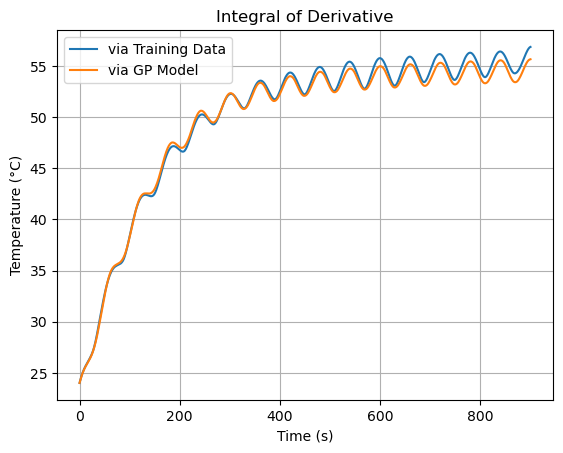

In [77]:
TS1_dGP = soln_GP.y[0]

plt.figure()
plt.plot(tvec, TS1_training)
plt.plot(tvec, TS1_dGP)
plt.grid()
plt.title('Integral of Derivative')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
_ = plt.legend(['via Training Data', 'via GP Model'])

Attempting to prevent phase shift by beginning integration after burn-in period:

In [92]:
t_start = [20, 40, 60]

t_burnin = []
soln_GP_burnin = []
for i in range(len(t_start)):
    t_burnin.append(np.linspace(t_start[i], tvec[-1], int(tvec[-1] - t_start[i])))
    soln_GP_burnin.append(solve_ivp(dy_GP, [t_burnin[i][0], t_burnin[i][-1]], [TS1_smooth[t_start[i]]], 'LSODA', t_burnin[i]))

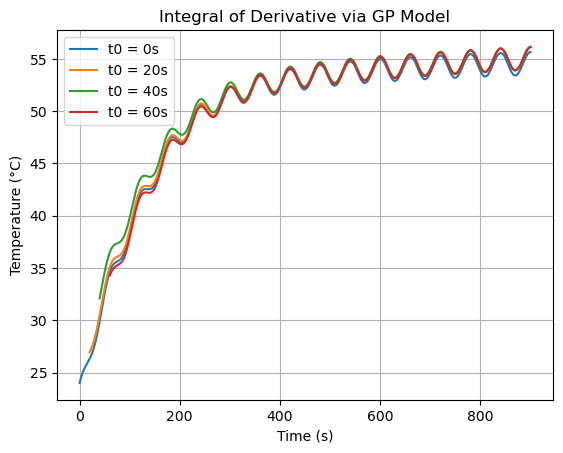

In [96]:
TS1_dGP_burnin = list(soln_GP_burnin[i].y[0] for i in range(len(t_start)))

plt.figure()
plt.plot(tvec, TS1_dGP, label="t0 = 0s")
for i in range(len(t_start)):
    plt.plot(t_burnin[i], TS1_dGP_burnin[i], label=f"t0 = {t_start[i]}s")
plt.grid()
plt.title('Integral of Derivative via GP Model')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
_ = plt.legend()

## Results

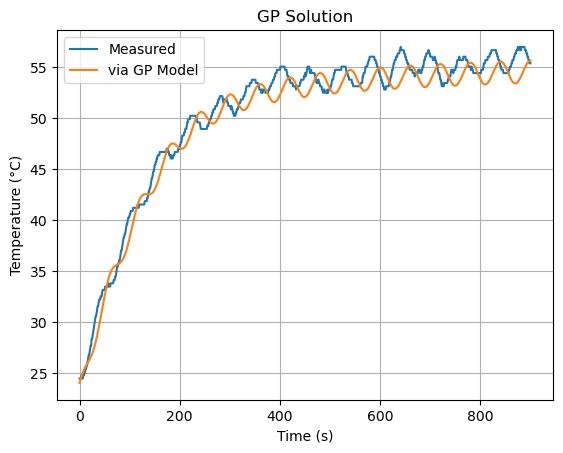

In [72]:
plt.figure()
plt.plot(tvec, TS1)
plt.plot(tvec, TS1_dGP)
plt.grid()
plt.title('GP Solution')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
_ = plt.legend(['Measured', 'via GP Model'])

## Conclusion

It is unknown why the phase shift occurs.
- The integral of $\mathbf{GP}_{\Delta T}$ aligns fairly well with the integral of the training data. However, the training data itself, i.e., the derivative of the smoothed measurements, qualitatively appears to have introduced the most error as a significant phase shift occurs in this step.
- It was hopeful that the majority of phase shift was introduced by the $Q_1$ analytic expression being slightly off. This could have made sense since the chain rule incorporates $\dot{Q}_1(t)$; however, since *pyomo_tclab_v4.1.ipynb* showed the equivalence of the chain rule with the numerical derivative using finite-differences, which does not depend on $\dot{Q}_1(t)$, the phase shift cannot be from the $Q_1$ analytic expression. Instead, finite differences implies that the start time $t_{\text{start}}$ of the GP ODE solver may be the source.
- In the above figure, since $t_{\text{start}}$ of the ODE for the GP appears negligible, the integration itself is unlikely to be the source of the phase shift.